### Installations, if needed

In [ ]:
# Install the right version of spaCy
!pip install spacy==2.0.12 # Above 2.0.12 doesn't seem work with the neuralcoref resolution (at least 2.0.13 and 2.0.16 don't)

In [ ]:
# Install the large Neural Coref model
!pip install https://github.com/huggingface/neuralcoref-models/releases/download/en_coref_lg-3.0.0/en_coref_lg-3.0.0.tar.gz # This is the coref language model

### Importing Libraries

In [ ]:
import spacy
import en_coref_lg
from spacy import displacy
import pandas as pd
import networkx as nx
import time
from graphviz import Source
import matplotlib.pyplot as plt

### Loading and previewing our export from OntoNotes5

In [2]:
JSON_FILENAME = 'ner_output_1.json'
FILEPATH_TO_JSON = "onto_sql_output/"

onto_import = pd.read_json(FILEPATH_TO_JSON + JSON_FILENAME)

In [3]:
onto_import.head()

,document_text,ner_end_word_index,ner_start_word_index,ner_string,ner_type,onto_sentence_parse,sent@doc_id,sentence_string
0,The explosion in Yemen did not help an already...,32,32,Israeli,NORP,(TOP (S (S (NP-SBJ (NP (DT The) (NN explosion)...,0@bn/abc/00/abc_0008@0008@abc@bn@en@on,The explosion in Yemen did not help an already...
1,The explosion in Yemen did not help an already...,34,34,Palestinian,NORP,(TOP (S (S (NP-SBJ (NP (DT The) (NN explosion)...,0@bn/abc/00/abc_0008@0008@abc@bn@en@on,The explosion in Yemen did not help an already...
2,The explosion in Yemen did not help an already...,3,3,Yemen,GPE,(TOP (S (S (NP-SBJ (NP (DT The) (NN explosion)...,0@bn/abc/00/abc_0008@0008@abc@bn@en@on,The explosion in Yemen did not help an already...
3,The explosion in Yemen did not help an already...,37,37,Egypt,GPE,(TOP (S (S (NP-SBJ (NP (DT The) (NN explosion)...,0@bn/abc/00/abc_0008@0008@abc@bn@en@on,The explosion in Yemen did not help an already...
4,The explosion in Yemen did not help an already...,42,39,the next several days,DATE,(TOP (S (S (NP-SBJ (NP (DT The) (NN explosion)...,0@bn/abc/00/abc_0008@0008@abc@bn@en@on,The explosion in Yemen did not help an already...


In [ ]:
onto_import.loc[0].sentence_string

### Loading the Large Neural Coref spaCy Model

In [4]:
nlp = en_coref_lg.load()

#### Using it to loop through dependency parsing for a selection of sentences

In [5]:
# Establish which sentence rows we want to work through right now
SENT_MIN = 0
SENT_MAX = 500

# Check the time and start parsing via spaCy
start_time = time.time()
onto_import["spacy_parse"] = onto_import.loc[SENT_MIN:SENT_MAX,:].apply(lambda x: nlp(x["sentence_string"]), axis=1)

# Calculate the duration 
duration = time.time() - start_time
print("Applying the spaCy pipeline took {0:.2f} seconds".format(duration))

Applying the spaCy pipeline took 9.37 seconds


### Viewing some example text, with highlighted named entities

In [ ]:
# Choose an entry integer to see its text and the parse below.
ENTRY = 490

displacy.render(onto_import.loc[ENTRY,"spacy_parse"], jupyter=True, style='ent')

#### Viewing dependencies

In [ ]:
displacy.render(onto_import.loc[ENTRY,"spacy_parse"], jupyter=True, style='dep')

#### Identifying some useful attributes of the spaCy tokens

In [ ]:
# This gives us the dependency type

onto_import.loc[490,"spacy_parse"][13].head

In [ ]:
# This gives us the token of its head, from which we can call other attributes of the head.

onto_import.loc[490,"spacy_parse"][13].head.i

In [ ]:
# If we just want the string of the head, that's here:

onto_import.loc[0,"spacy_parse"][32].head.text

In [ ]:
# If we want the index of the head within the sentence (to find when a multi-word NE
# depends on something outside of that NE phrase)

onto_import.loc[0,"spacy_parse"][32].head.i

### Creating a Dictionary with a Graph for Each NER Type

In [ ]:
graphs_dict = dict()

#### Defining a function to graph by row

In [ ]:
def graph_row(df_row):
    ner_type = str(df_row["ner_type"])

    # Retrieve our Directed Graph for this NE Type or create a new one
    G = graphs_dict.get(ner_type, nx.DiGraph())
    
    # For each row, add a node for the Named Entity's type
    G.add_node(ner_type)
    node_weight = G.nodes[ner_type].get('weight', 0)
    G.nodes[ner_type]['weight'] = node_weight + 1

    # If it's a phrase, let's find the node that reaches outside the range of this phrase:
    head_index = df_row["ner_end_word_index"]
    head_of_phrase = df_row["spacy_parse"][head_index]
        
    # Get the explanation of its dependency type in this usage
    explanation = spacy.explain(head_of_phrase.dep_)
    
    # If no explanation, revert to the raw dependency type.
    if explanation is None:
        explanation = head_of_phrase.dep_
    
    # Trying to catch and diagnose some problem cases
    elif explanation == "punctuation":
        print("NE '{1}' marked as punctuation in sentence '{0}'".format(df_row["sentence_string"], df_row["ner_string"]))
        print(" --- ")
    elif explanation == "determiner":
        print("NE '{1}' marked as determiner in sentence '{0}'".format(df_row["sentence_string"], df_row["ner_string"]))
        print(" --- ")

    # Object of preposition doesn't do much, so let's see what's on the other side of that.
    elif explanation == "object of preposition":
        explanation = "head of prep phrase"
        # move to the preposition so we get its head later on when adding node
        head_of_phrase = head_of_phrase.head
        
    # Add a node for that explanation, and connect that to the main entity
    G.add_node(explanation)
    explanation_weight = G.nodes[explanation].get('weight', 0)
    G.nodes[explanation]['weight'] = explanation_weight + 1
    G.add_edge(ner_type, explanation)
    edge_weight = G[ner_type][explanation].get('weight', 0)
    G[ner_type][explanation]['weight'] = edge_weight + 1
    
    # Add a node from the dependency type to the head of the phrase head's index, and connect that
    # to the dependency type
    norm = head_of_phrase.head.norm_
    G.add_edge(explanation, norm)
    norm_edge_weight = G[explanation][norm].get('weight', 0)
    G[explanation][norm]['weight'] = norm_edge_weight + 1
    
    graphs_dict[ner_type] = G

#### Applying that to our selected rows of our dataframe

In [ ]:
_ = onto_import.loc[SENT_MIN:SENT_MAX,:].apply(lambda x: graph_row(x), axis=1)

#### Draw the graphs for the Named Entity Types

In [ ]:
for key, value in graphs_dict.items():
    
    graph_filepath = 'NER_Type_Graphs/'
    graph_filename = 'G_' + str(key)

    # Write our graph to DOT format to be read and visualized by GraphViz
    nx.drawing.nx_pydot.write_dot(value, graph_filepath + graph_filename)

    # Load the saved DOT format
    graph_visualized = Source.from_file(graph_filepath + graph_filename, engine='neato')

    # Uncomment the following line to show all graphs.
    #display(graph_visualized)
    
    with open(graph_filepath + graph_filename, "r") as file:
        graph_dot = file.readlines()
        graph_dot.insert(1,'graph [overlap = scale, layout = neato];\n')
        
    with open(graph_filepath + graph_filename, "w") as file:
        file.writelines(graph_dot)

    # Save it to an svg
    graph_visualized.render(filename=graph_filepath + graph_filename,format='svg') #, cleanup='true')

# View just one in the notebook
graph_visualized

### Graphing a Candidate Named Entity

In [36]:
# Defining helper functions to build the candidate graphs

def reconcile_ents_and_clusters(doc):
    """"Reconcile the coreference and entities lists into a
        a single dict of graphs to make.
        
        Keys are (start.idx, end.idx) tuples.
        Values are (spaCy.Span, graph_id) tuples."""
    
    # A dictionary with key of 
    occurence_ind  = {}
    
    cluster_offset = 0
    if doc._.has_coref:
        cluster_offset = len(doc._.coref_clusters)
        for cluster_idx, cluster in enumerate(doc._.coref_clusters):
            for mention in cluster:
                key = (mention.start, mention.end)
                occurence_ind[key] = (mention, cluster_idx)
    
    # Now let's see if each ent is in there. If not, we'll add it to
    # our cluster list.
    new_cluster_idx = 0
    
    for ent_ind, ent in enumerate(doc.ents):
        key = (ent.start, ent.end)
        try:
            occurence_ind[key]
        except:
            occurence_ind[key] = (ent, cluster_offset + new_cluster_idx)
            new_cluster_idx += 1
    return occurence_ind

def graph_entity(ent, doc, G, root_node):
    
    NO_OF_GENERATIONS = 2
    
    # Assume the head of the phrase, if it is a phrase, is the last word
    # in the phrase.
    head_of_phrase = ent[-1]
    
    nodes_needing_head_branches = [(head_of_phrase, root_node)]
    next_head_nodes = []
    nodes_needing_child_branches = [(head_of_phrase, root_node)]
    next_child_nodes = []
    
    while NO_OF_GENERATIONS >= 0:
        NO_OF_GENERATIONS -= 1
        
        for (node, child_label) in nodes_needing_head_branches:
            print("graphing node: {0}".format(node.norm_))
            try: 
                # Get the explanation of its relation arc in this usage
                relation = spacy.explain(node.dep_)
                # If no explanation, revert to the raw dependency type.
                if relation is None:
                    relation = node.dep_

                # Object of preposition doesn't do much, so let's see what's on the other side of that.
                elif relation == "object of preposition":
                    relation = "head of prep phrase"
                    # move to the preposition so we get its head later on when adding node
                    node = node.head
                    
                intermediary_node_label = "head " + relation

                # Add a node for the relation, and connect that to the main entity
                G.add_node(intermediary_node_label)
                print("adding node to graph: {0}".format(intermediary_node_label))
                G.add_edge(child_label, intermediary_node_label, label="head")

                # Add a node from the relation to the entity's head, and connect that
                # to the relation type
                normed_head = node.head.norm_
                print("adding node to graph: {0}".format(normed_head))
                G.add_node(normed_head)
                G.add_edge(intermediary_node_label, normed_head)
                
                if node.head != node:
                    print("will get head of: {0}".format(normed_head))
                    next_head_nodes.append((node.head, node.text))
            except:
                print("passed in head")
                pass
        nodes_needing_head_branches = next_head_nodes
        next_head_nodes = []
        for (node, parent_label) in nodes_needing_child_branches:
            try:
                for child in node.children:
                    relation = spacy.explain(child.dep_)
                    # If no explanation, revert to the raw dependency type.
                    if relation is None:
                        relation = node.dep_
                    intermediary_node_label = "child " + relation

                    G.add_node(intermediary_node_label)
                    G.add_edge(parent_label, intermediary_node_label, label="child")
                    print("added child edge from {0} to {1}".format(parent_label, intermediary_node_label))
                    
                    normed_child = child.norm_
                    G.add_node(normed_child)
                    print("adding child node: {0}".format(normed_child))
                    G.add_edge(intermediary_node_label, normed_child)
                    
                    next_child_nodes.append((child, node.text))
            except:
                print("passed in child")
                pass                
        nodes_needing_child_branches = next_child_nodes
        next_child_nodes = []
    return G
    
def graph_candidates_in_doc(candidate_text):
    
    doc = nlp(candidate_text)
    
    clustered_ents = reconcile_ents_and_clusters(doc)
    
    # Initialize a graph for each clustered_ent
    candidate_graphs = dict()
    
    for ((start_idx, end_idx), (ent,graph_idx)) in clustered_ents.items():
        
        # Get the cluster's existing graph from previous mentions
        # or create a new one.
        G = candidate_graphs.get(graph_idx, nx.DiGraph())
        
        # Make sure we have our root. No harm done if it already exists.
        # If it's a cluster, we get the Span of the most representative
        # mention in the cluster
        try:
            root_node = doc._.coref_clusters[graph_idx].main.text
        # If it's not, we just use the ent name
        except:
            root_node = ent.text
        G.add_node(root_node)
        
        # A helper function adds the rest of the graph
        print("\nGraphing entity: {0}".format(ent.text))
        candidate_graphs[graph_idx] = graph_entity(ent, doc, G, root_node)
    
    #graph_entity(ent, doc) for ent in doc.ents]
    return candidate_graphs

#### Applying the functions on a selected article

In [42]:
TEST_ENTRY = 90
test_candidate_text = onto_import.loc[TEST_ENTRY,"document_text"]
print(test_candidate_text)

test_graphs = graph_candidates_in_doc(test_candidate_text)

President Clinton is off to Asia .
He 'll go first to Brunei for a meeting of Asia - Pacific nations , then to Vietnam Thursday .
Mr. Clinton will be the first U.S. President 0 *T*-1 to visit the country since the Vietnam War ended in 1975 .

Graphing entity: President Clinton
graphing node: Clinton
adding node to graph: head nominal subject
adding node to graph: is
will get head of: is
added child edge from President Clinton to child nsubj
adding child node: President
graphing node: is
adding node to graph: head ROOT
adding node to graph: is

Graphing entity: He
graphing node: he
adding node to graph: head nominal subject
adding node to graph: go
will get head of: go
graphing node: go
adding node to graph: head ROOT
adding node to graph: go

Graphing entity: Mr. Clinton
graphing node: Clinton
adding node to graph: head nominal subject
adding node to graph: be
will get head of: be
added child edge from President Clinton to child nsubj
adding child node: Mr.
graphing node: be
adding nod

#### Holding area for some tests

In [44]:
# Some tests
TEST_ENTRY = 90
doc = nlp(onto_import.loc[TEST_ENTRY,"document_text"])

# Testing to make sure all the ents are present in the reconciled list
reconciled = reconcile_ents_and_clusters(doc)
for key in [(ent.start, ent.end) for ent in doc.ents]:
    assert key in reconciled.keys()

#### Draw the candidate graphs and preview one

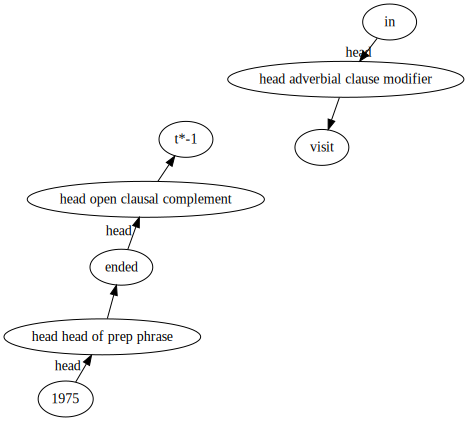

In [43]:
for key, value in test_graphs.items():
    
    graph_filepath = 'NER_Type_Graphs/'
    graph_filename = 'G_' + str(key)

    # Write our graph to DOT format to be read and visualized by GraphViz
    nx.drawing.nx_pydot.write_dot(value, graph_filepath + graph_filename)

    # Load the saved DOT format
    graph_visualized = Source.from_file(graph_filepath + graph_filename, engine='neato')

    # Uncomment the following line to show all graphs.
    #display(graph_visualized)
    
    with open(graph_filepath + graph_filename, "r") as file:
        graph_dot = file.readlines()
        graph_dot.insert(1,'graph [overlap = scale, layout = neato];\n')
        
    with open(graph_filepath + graph_filename, "w") as file:
        file.writelines(graph_dot)

    # Save it to an svg
    graph_visualized.render(filename=graph_filepath + graph_filename,format='svg', cleanup='true')

# View just one in the notebook
graph_visualized